<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/RL_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Packages

In [1]:
# restart runtime after running and skip this cell
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 3.0 MB/s eta 0:00:00


##2. Import Packages

In [2]:
import numpyro
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
from typing import List, Callable
from functools import partial
from tqdm import tqdm

##3. Create Simple RL Model

In [3]:
def softmax(qs, tau):
  safe_tau = np.abs(tau) + 1e-2
  return np.exp(qs/safe_tau) / np.exp(qs/safe_tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [4]:
class Distribution:

  def __init__(self, func: Callable, kwargs):
    self.func: Callable = partial(func, **kwargs)

  def __call__(self):
    return self.func.__call__()

In [5]:
class SimpleRL:

  def __init__(self, n_trials: int, distributions: List[Distribution]):
    self.n_choices: int = len(distributions)
    self.n_trials: int = n_trials
    self.distributions: List[Distribution] = distributions
    self.qs: np.array = np.ones((self.n_choices,)) * 0.    #  check whether I should set to 0.5
    self.q_trace: np.array = np.ones((self.n_trials,self.n_choices))
    self.rewards: np.array = np.zeros((self.n_trials),dtype=np.int32)
    self.choices: np.array = np.zeros((self.n_trials),dtype=np.int32)

  def simulate(self, alpha, temperature):
    for i in range(self.n_trials):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      ps = softmax(self.qs,temperature)
      # choice made based on weighted probabilities of Q-values
      choice = np.random.choice(a=self.n_choices,size=1,p=ps)[0]
      # choice is recorded to trace
      self.choices[i] = choice
      # reward calculated
      dist = self.distributions[choice]  # supply a list of distributions to choose from
      reward = dist()  # sample from distribution by calling it
      # Q-values updated
      self.rewards[i] = reward
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    # main data to be returned (basis for fits), is choices and rewards per trial
    return self.rewards, self.choices

##4. Simulate Model

In [6]:
seed = 0
np.random.seed(seed)
mean_rewards = [-0.3,0.7]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
n_trials = 1000
temperature = 1
alpha = 0.01

In [7]:
rl_model = SimpleRL(n_trials=n_trials, distributions=dists)
rewards, choices = rl_model.simulate(alpha,temperature)
qs = rl_model.q_trace

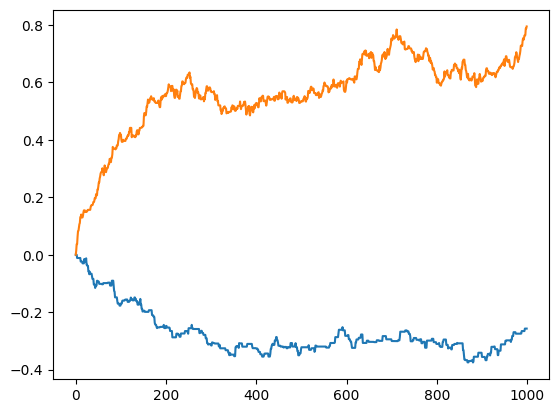

In [8]:
# plotting q values
plt.plot(qs)

##5. Create Loglikelihood Function in PyTensor

###5a. Simulate RL

In [ ]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.ivector("R") # reward vector
Q = pt.dvector("Q") # empty matrix to store q-values across trials
a = pt.scalar("a") # learning rate

# function for a single RL step
def rl_step(c, r, q_tm1):
  m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
  rm = r * m
  qm = q_tm1 * m
  return qm + a * (rm - qm)

# scan function build
Qs, updates = pytensor.scan(rl_step, sequences=[C,R], outputs_info=Q)

# Q Prediction function compilation
q_predict = pytensor.function(inputs=[C, R, Q, a], outputs=Qs)

# test values
C_test = np.ones((100,), dtype=np.int32)
R_test = np.ones((100,), dtype=np.int32)
Q_test = np.zeros(shape=(2,), dtype=pytensor.config.floatX)
a_test = 0.1

# RL Model function test
q_predict(C_test,R_test,Q_test,a_test)

###5b. Calculate Loglikelihood of Simulation given parameters

In [55]:
b = pt.dscalar("b")
ll = pt.dscalar("q_select")

def ll_def(c, qs, ll):
  mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
  ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
  p_select = (ps * mask).sum()
  ll = pt.log(p_select)
  return ll

loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], outputs_info=ll)
# look in jax documentation for resolution
# Ps = pt.exp(Qs/b) / pt.exp(Qs/b).sum()
# P_select = pt.set_subtensor(pt.zeros_like(Ps)[C],pt.constant(1.))
# P_select = pt.zeros_like(Ps).transpose()
# n_choices = 2
# # for i in range(n_choices):
# P_select = pt.where(pt.eq(C,pt.constant(1)),
#                     pt.set_subtensor(P_select[C],pt.constant(1)),
#                     pt.set_subtensor(P_select[C],pt.constant(0)))
# loglikes = pt.log(P_select.sum(axis=1)).transpose()
loglike = loglikes.sum()

# update to use pt.where and pt.set_subtensor
# loglikes = pt.where(C==0,pt.)

def make_ll_func(C,R):
  def ll_func(a,b):
    return loglike
  return ll_func

ll_func = make_ll_func(C,R)

output = ll_func(a,b)

loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=loglike)

np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
# mask_test = np.zeros((n_choices,), dtype=np.int32)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
# print(choice_mask_func(mask_test, C_test))
# Q_pred = q_predict(C_test,R_test,Q_test,a_test)
# print(Ps_func(Q_pred,b_test))
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)
# loglike_func(C_test,R_test,Q_test,a_test,b_test)

UnusedInputError: ignored

In [69]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.ivector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.scalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def make_ll_func(C,R,Q,ll):
  def ll_func(a,b):
    # function for a single RL step
    def rl_step(c, r, q_tm1):
      m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
      rm = r * m
      qm = q_tm1 * m
      return qm + a * (rm - qm)

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], outputs_info=Q)

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll):
      mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
      ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
      p_select = (ps * mask).sum()
      ll = pt.log(p_select)
      return ll

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], outputs_info=ll)

    # final output
    loglike = loglikes.sum()
    return loglike
  return ll_func

ll_func = make_ll_func(C,R,Q,ll)

output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

array(-59.19219022)

In [ ]:
# P_select_test = pytensor.function(inputs=[C,R,Q,a,b],outputs=P_select)
# loglikes_test = pytensor.function(inputs=[C,R,Q,a,b],outputs=loglikes)

# P_select_test(C_test,R_test,Q_test,a_test,b_test).transpose()

In [ ]:
# loglikes_test(C_test,R_test,Q_test,a_test,b_test)

##6. Calculate Likelihoods

In [40]:
# Creating Ground Truth Data
n_trials = 100
mean_rewards = [-0.3,0.7]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
# Creating Ground Truth Choices
a_true = 0.1
b_true = 0.8
rl_model = SimpleRL(n_trials=n_trials,distributions=dists)
R_true, C_true = rl_model.simulate(a_true,b_true)

In [53]:
# blackbox loglikelihood function for RL Model
# def rl_ll(params,R,C):
#   a, b = params
#   m = np.max(C)
#   q = np.zeros((m+1,))
#   Q_predict = q_predict(C,R,q,a)
#   probabilities = softmax(Q_predict, b)
#   selected_probabilities = probabilities[:, C]
#   log_likelihood = np.sum(np.log(selected_probabilities))
#   return log_likelihood

# rl_ll((a_true,b_true),R_true,C_true)

##7. PyMC Likelihood Modelling

Wrapping model into PyMC using pm potential

Code was taken from PyMC documentation and modified

In [73]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, c, r):
        # add inputs as class attributes
        self.likelihood = loglike
        self.C = c
        self.R = r

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      outputs[0][0] = self.likelihood(theta[0], theta[1])
      # a,b = theta
      # outputs[0][0] = self.likelihood(self.C, self.R, self.Qs, self.ll, a, b)


In [76]:
# set up our data
ll_true = 0
Qs_true = pt.ones((2,)) * 0.5
C_true, R_true, a_true, b_true

ll_func = make_ll_func(C_true,R_true,Qs_true,ll_true)

# create our Op
logl = LogLike(ll_func, C_true, R_true)

# use PyMC to sampler from log-likelihood
with pm.Model():
    # Priors
    a = pm.Beta(name="a",alpha=10,beta=10)
    b = pm.Beta(name="b",alpha=10,beta=10)

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([a, b])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="pymc")

# plot the traces
az.plot_trace(idata_mh, lines=[("m", {}, a_true), ("c", {}, b_true)]);

TypeError: ignored

In [ ]:
az.plot_pair(idata_mh, kind="kde")

##8. Model Calibration

In [ ]:
def fit_pymc(R,C,priors):
  # create our Op
  logl = LogLike(loglike_func, R, C)
  # use PyMC to sampler from log-likelihood
  with pm.Model():
      # uniform priors on m and c
      prior_dists, prior_args = priors
      a = prior_dists[0](*prior_args[0])
      b = prior_dists[1](*prior_args[1])
      # convert m and c to a tensor vector
      theta = pt.as_tensor_variable([a, b])
      # use a Potential to "call" the Op and include it in the logp computation
      pm.Potential("likelihood", logl(theta))
      # Use custom number of draws to replace the HMC based defaults
      idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")
  return idata_mh

In [ ]:
# Calibration Parameters
nrep = 10
trials = 500
a_range = (0.01,0.99)
b_range = (0.01,0.99)
mean_rewards = [-0.3,0.7]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
prior_dist = (pm.Uniform, pm.Uniform)
prior_args = (["a", 1e-4, 1e-0],
              ["b", 1e-4, 1e+0])  # alpha=1, beta=1; alpha=10 beta=10
priors = (prior_dist, prior_args)
# Calibrator Functions
def sample(n_trials,dists,a,b):
  return SimpleRL(n_trials=n_trials,distributions=dists).simulate(alpha=a,temperature=b)

In [ ]:
# quantiles = np.zeros((nrep,2))
# for rep_i in tqdm(range(nrep)):
#   a_true = np.random.uniform(*a_range)
#   b_true = np.random.uniform(*b_range)
#   y_R, y_C = sample(trials,dists,a_true,b_true)
#   data = fit_pymc(y_R, y_C, priors)
#   quantiles[rep_i,0] = np.mean(data.posterior.a > a_true)
#   quantiles[rep_i,1] = np.mean(data.posterior.b > b_true)
#   az.plot_trace(data, lines=[("m", {}, a_true), ("c", {}, b_true)])

In [ ]:
# plt.hist(quantiles[:,0])
# plt.show()
# plt.hist(quantiles[:,1])
# plt.show()
# quantiles

##9. Hierarchical Bayes for Reinforcment Learning

Create Multi-participant RL data

In [ ]:
class MultiRL:

  def __init__(self, n_trials: int, n_participants: int, distributions: List[Distribution]):
    self.participants: List[SimpleRL] = [
        SimpleRL(n_trials, distributions) for _ in range(n_participants)
    ]
    self.alphas = list()
    self.temperatures = list()

  def simulate(self, alpha_a, alpha_b, temperature_a, temperature_b):
    group_data = []
    for idx, participant_model in enumerate(self.participants):
      # sample participant parameters
      alpha = np.random.beta(alpha_a, alpha_b)
      temperature = np.random.beta(temperature_a, temperature_b)
      self.alphas.append(alpha)
      self.temperatures.append(temperature)
      participant_rewards, participants_choices = np.vstack(participant_model.simulate(alpha, temperature))
      assert sum(np.isnan(participant_rewards)) == 0, participant_rewards
      trial_col = np.arange(participant_model.n_trials).reshape((-1,1))
      idx_col = np.ones_like(trial_col) * idx
      group_data.append(np.concatenate([idx_col,participant_rewards.reshape((-1,1)),participants_choices.reshape((-1,1)),trial_col],axis=1))
    return np.concatenate(group_data)


In [ ]:
multi_rl_model = MultiRL(n_trials=50,n_participants=5,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)
data.shape

Create Hierarchical Model - update for RL

In [ ]:
# define a pytensor Op for our likelihood function
class MultiLogLike(pt.Op):

    itypes = [pt.dmatrix]  # expects a matrix of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, r, c, ids):
        # add inputs as class attributes
        self.likelihood = loglike
        self.R = r
        self.C = c
        self.ids = ids

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      total = 0
      # total = np.zeros((len(self.ids.unique())))
      for i, id in enumerate(self.ids.unique()):
        id_index = self.ids.loc[self.ids == id]
        r = self.R.loc[id_index]
        c = self.C.loc[id_index]
        a = theta[0][i]
        b = theta[1][i]
        total += self.likelihood((a,b), r, c)
      outputs[0][0] = np.array(total)

In [ ]:
df = pd.DataFrame(data=data,columns=['Participant_ID','Rewards','Choices','Trial_Num'])
participant_ids, participants = pd.factorize(df['Participant_ID'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}
mlogl = MultiLogLike(loglike_func, df['Rewards'], df['Choices'],df['Participant_ID'])

In [ ]:
with pm.Model(coords=coords) as hierarchical_model:

    # Hyperpriors for group nodes
    alpha_a = pm.HalfNormal(name="alpha_a", sigma=1.0)
    beta_a = pm.HalfNormal(name="beta_a", sigma=1.0)
    alpha_b = pm.HalfNormal(name="alpha_b", sigma=1.0)
    beta_b = pm.HalfNormal(name="beta_b", sigma=1.0)

    # Intercept for each participant, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_participants).
    a = pm.Beta(name="a",alpha=alpha_a,beta=beta_a,dims="Participant")
    b = pm.Beta(name="b",alpha=alpha_b,beta=beta_b,dims="Participant")

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([a, b])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", mlogl(theta))
    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")

In [ ]:
az.plot_trace(idata_mh);  # real and assumed disributions differed ; limited parameter values

In [ ]:
az.rcParams['plot.max_subplots'] = 100
az.plot_pair(idata_mh, kind="kde")

In [ ]:
az.plot_trace(idata_mh);  # bad beta values